In [6]:
import subprocess
import json
import os
import numpy as np
import pytrec_eval
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

def custom_precision_recall_fscore(ytrue, ypred):
    false_positives=0
    true_positives=0
    num_of_cands=sum(ypred)
    for i in range(len(ypred)):
        if ypred[i] == 1:
            if ytrue[i]:
                true_positives+=1
            else:
                false_positives+=1
    try:
        pre=true_positives/num_of_cands
    except:
        #num_of_cands == 0
        pre = 1
    try:
        rec=true_positives/sum(ytrue)
    except:
        #false_negatives == 0:
        if true_positives==0:
            rec=0
        else:
            rec = 1
    if (pre+rec)<0.001:
        f1=0
    else:
        f1=2*pre*rec/(pre+rec)
    
    return pre,rec,f1

custom_precision_recall_fscore([1, 1, 0, 0, 0] ,[1, 1, 0, 1, 1])

(0.5, 1.0, 0.6666666666666666)

In [2]:
class Model():
    def __init__(self,modelpath,testdata):
        self.modelpath=modelpath
        self.testdata=testdata
        
    def run(self):
        process = subprocess.Popen(['python3 -m parlai.scripts.interactive -m transformer/polyencoder -mf '+self.modelpath+' --single-turn True --inference topp --topp 10 --ground-truth-path '+self.testdata], shell=True,
                             stdout=subprocess.PIPE,
                             stdin=subprocess.PIPE,
                            env={})

        for i in range(200):
            line = process.stdout.readline()
            line = line.strip().decode()
            print(line)
            if line == '[  polyencoder_type: codes ]':
                break

        run_cos_score={}
        run_orig_score={}
        for qid in range(254): #254
            qid=str(qid)
            print(qid)
            query_id = "q%s" % qid

            run_cos_score[query_id]={}
            run_orig_score[query_id]={}

            process.stdin.write(qid.encode('utf-8'))
            #p.stdin.write("\n")
            process.stdin.write(b"\n")
            process.stdin.flush()
            line=''
            while 'cosine_scores: tensor' not in line: # Exclude other messages
                line = process.stdout.readline()
                line = line.strip().decode()
                print(line)

            line = line.split('cosine_scores: tensor')
            line=line[-1]
            cosine_score=line.translate({ord('('): None,ord(')'): None,ord('['): None,ord(']'): None}).split(',')
            cosine_score=[float(s) for s in cosine_score]

            line = process.stdout.readline()
            line = line.strip().decode()
            print(line)
            line = line.split('scores: tensor')
            line=line[-1]
            score=line.translate({ord('('): None,ord(')'): None,ord('['): None,ord(']'): None}).split(',')
            score=[float(s) for s in score]
            for did in range(len(score)):
                doc_id = "d%s"%did
                run_cos_score[query_id][doc_id]=cosine_score[did]
                run_orig_score[query_id][doc_id]=score[did]
                
        self.run_cos_score=run_cos_score
        self.run_orig_score=run_orig_score
        
        with open('allcands.json', 'r') as f:
            allcands = json.load(f)
        with open('groundtruth.json', 'r') as f:
            groundtruth = json.load(f)
        with open('Q.json', 'r') as f:
            Q = json.load(f)

        qrel={}
        for qid in range(254):
            query_id = "q%s" % qid
            qrel[query_id]={}

            cands=allcands[qid]
            for did in range(len(cands)):
                doc_id = "d%s"%did
                if cands[did] in groundtruth[qid]:
                    qrel[query_id][doc_id]=1
                else:
                    qrel[query_id][doc_id]=0
        self.qrel=qrel
        
    
    def rocplot(self,thre_start=0,thre_end=30,step=0.5,saveto="../results/roc.png"):
        self.ts=[]
        self.ps=[]
        self.rs=[]
        self.fs=[]

        for thre in np.arange(thre_start,thre_end,step):
            ps_i=[]
            rs_i=[]
            fs_i=[]
            for qid in range(254): #254
                query_id= "q%s" % qid
                ytrue=[]
                ypred=[]
                for did in range(len(self.run_orig_score[query_id])):
                    doc_id = "d%s"%did
                    ytrue.append(self.qrel[query_id][doc_id])
                    ypred.append(int(self.run_orig_score[query_id][doc_id]>thre))

                p, r, f = custom_precision_recall_fscore(ytrue, ypred)
                #p, r, f, temp = precision_recall_fscore_support(ytrue, ypred, average='binary')
                ps_i.append(p)
                rs_i.append(r)
                fs_i.append(f)

            self.ts.append(thre)
            self.ps.append(np.mean(ps_i))
            self.rs.append(np.mean(rs_i))
            self.fs.append(2*self.ps[-1]*self.rs[-1]/(self.ps[-1]+self.rs[-1]))
        
        if not os.path.isdir('../results/'):
            os.mkdir('../results/')
            
        #with open("../results/p_r_f1.tsv", "w") as fout:
        #    for t, p , r, f in zip(ts, ps, rs, fs):
        #        print("%.4f\t%.4f\t%.4f\t%.4f"%(t, p, r, f), file=fout)

        plt.figure(figsize=(15,10))
        plt.plot(self.ts, self.ps, label = "Precision", marker=".", markersize=8, color="black")
        plt.plot(self.ts, self.rs, label = "Recall", marker="*", markersize=8, color="black")
        plt.plot(self.ts, self.fs, label = "F1", marker="x", markersize=8, color="black")
        plt.xlabel('Threshold', size=15)
        # Set the y axis label of the current axis.
        plt.ylabel('Metrics', size=15)
        # Set a title of the current axes.
        plt.title('Precision/Recall/F1', size=15)
        #plt.ylim(0,1)
        #plt.xlim(0,0.97)
        #plt.yticks(np.arange(0, 1, 0.05), size=12)
        #plt.xticks(np.arange(0, 0.98, 0.05), size=12)
        plt.legend(fontsize=15)
        plt.grid()
        plt.savefig(saveto)
        plt.show()
        
    def trec_eval(self,metrics=['map', 'ndcg_cut_1','ndcg_cut_3']):
        evaluator = pytrec_eval.RelevanceEvaluator(
            self.qrel, {key for key in metrics})
        result=evaluator.evaluate(self.run_cos_score)

        self.metrics={}
        for m in metrics:
            values=[]
            for query_result in result.values():
                values.append(query_result[m])
            self.metrics[m]=np.mean(values)
            
        print(self.metrics)

In [3]:
modelQA=Model('../model/covid8','../ROCdata/testQA.tsv')
modelQA.run()

[ warning: overriding opt['model_file'] to ../model/covid8 (previously: model/poly2/covid8 )]
[ warning: overriding opt['single_turn'] to True (previously: None )]
[ warning: overriding opt['inference'] to topp (previously: max )]
[ warning: overriding opt['topp'] to 10.0 (previously: None )]
[ warning: overriding opt['ground_truth_path'] to ../ROCdata/testQA.tsv (previously: None )]
Dictionary: loading dictionary from ../model/covid8.dict
[ num words =  54944 ]
[Polyencoder: full interactive mode on.]
[setting fixed_candidates path to: ../model/covid8.cands-convai2.cands ]
Total parameters: 256131072
Trainable parameters:  256131072
Loading existing model parameters from ../model/covid8
[ Loading fixed candidate set from ../model/covid8.cands-convai2.cands ]
[ Loading fixed candidate set vectors from ../model/covid8.covid8.cands-convai2.vecs ]
[ Loading fixed candidate set encodings from ../model/covid8.covid8.cands-convai2.encs ]
opening ground_truth_path
successfully opened ground_t

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.4201, 0.4141, 0.4310, 0.3909, 0.2236]])
original_scores: tensor([23.5221, 22.5940, 23.9517, 21.6537, 12.3892])
7
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: MERS-CoV is one type of coronavirus. It is different type from the type of coronavirus that causes COVID-19. MERS-CoV stands for "Middle East Respiratory Syndrome- associated Coronavirus."The first cases of MERS-CoV were seen in 2012 in Saudi Arabia. MERS-CoV symptoms are fever, cough, and shortness of breath. People with this disease usually do not get sick from one another unless they are in very close contact.
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.2285, 0.2262, 0.1328, 0.1692, 0.1777]])
original_scores: tensor([11.0298, 10.9873,  6.3020,  8.3333,  8.6564])
18
precision: 0.5
recall: 1.0
f1: 0.6666666666666666
[Polyencoder]: Sorry, I don't know how to answer that.
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.3594, 0.3594, 0.1783, 0.0872, 0.0848]])
original_scores: tensor([19.5143, 19.5143,  9.4690,  4.5520,  4.3160])
19
precision: 1.0
recall: 1.0
f1: 1.0
[Polyencoder]: Face masks, including fabric ones, are likely only helpful in preventing people who have COVID-19 from spreading 

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.4548, 0.4548, 0.2909, 0.2620, 0.4548]])
original_scores: tensor([24.1885, 24.1885, 13.8922, 12.0932, 24.1885])
26
precision: 0.8
recall: 1.3333333333333333
f1: 1.0
[Polyencoder]: Face masks, including fabric ones, are likely only helpful in preventing people who have COVID-19 from spreading it to others. If you wear a cloth mask, you should still use the same social distancing measures as you would if you were not wearing a mask. This means you should stay at least 6 feet (2 meters) away from other people, wash your hands frequently, and avoid touching your face or eyes.When wearing a mask, make sure it covers your nose and mouth. Wash the mask after you use it every time. When handling the mask, act as though the front of the mask is con

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.3895, 0.4303, 0.2094, 0.1967, 0.2312]])
original_scores: tensor([21.0536, 22.4604, 10.9861, 11.2205, 13.1869])
34
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: To learn if there is Covid-19 where you live, check this world map with up-to-date details on the number of confirmed COVID-19 cases: https://coronavirus.jhu.edu/map.html
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.4006, 0.3896, 0.2977, 0.3395, 0.3819]])
original_scores: tensor([22.2380, 21.6216, 16.2488, 19.0062, 20.8783])
35
precision: 0.2
recall: 1.0
f1: 

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.5753, 0.2671, 0.4281, 0.2897, 0.2839]])
original_scores: tensor([31.2386, 14.7158, 24.3247, 15.5705, 15.2573])
43
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: A recent study shows that the virus can live in the air and on surfaces from several hours to several days. On plastic, it can live for up to 72 hours (3 days). On stainless steel, it can live for up to 48 hours (2 days). On cardboard, it can live up to 24 hours (1 day). On copper, it can live up to four hours. It is detectable in the air for up to three hours. However, the amount of virus that remains is quite minimal - so the risk is still relatively low to contract COVID19 from these surfaces.  It is still important to regularly clean and disinfect high-touch

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.4398, 0.3423, 0.4477, 0.3560, 0.2973]])
original_scores: tensor([23.0869, 18.8007, 25.2310, 20.3675, 16.1246])
51
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: Current thinking is that COVID-19 mostly spreads from person to person through respiratory droplets. But some studies show that the virus can last on surfaces, so it is possible that someone could get the virus by touching a surface that has the virus on it and then touching their mouth, nose, or eyes.
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.3819, 0.1361

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.4931, 0.4589, 0.4510, 0.3824, 0.4616]])
original_scores: tensor([26.1984, 23.8946, 24.0641, 19.9628, 23.6885])
60
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: Those who are infected with COVID-19 may have little to no symptoms. You may not know you have symptoms of COVID-19 because they are similar to a cold or flu. Symptoms haveincluded:cough fever difficulty breathing pneumonia in both lungsIn severe cases, infection can leadto death.Symptoms may take up to 14 days to appear after exposure to COVID-19. This is the longest known incubation period for this disease.Recent evidence indicates that the virus can be transmitted to othersfrom someone who is infected but not showing symptoms. This includes peoplewho:have not

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.4249, 0.4215, 0.1525, 0.5012, 0.4094]])
original_scores: tensor([23.8466, 23.0140,  8.3064, 27.7740, 21.5109])
68
precision: 0.25
recall: 1.0
f1: 0.4
[Polyencoder]: Current thinking is that COVID-19 mostly spreads from person to person through respiratory droplets. But some studies show that the virus can last on surfaces, so it is possible that someone could get the virus by touching a surface that has the virus on it and then touching their mouth, nose, or eyes.
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.5625, 0.2931, 0.2614, 0.437

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.4089, 0.3128, 0.0867, 0.1466, 0.2780]])
original_scores: tensor([22.1592, 16.4476,  4.4861,  7.8680, 14.4985])
77
precision: 0.3333333333333333
recall: 1.0
f1: 0.5
[Polyencoder]: COVID-19 stands for corona (CO), virus (VI), disease (D). The number "19" means it was first found in the year 2019.
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.3895, 0.4303, 0.2094, 0.1967, 0.2312]])
original_scores: tensor([21.0536, 22.4604, 10.9861, 11.2205, 13.1869])
78
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: To learn if there is

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.4965, 0.4661, 0.4424, 0.4095, 0.4626]])
original_scores: tensor([26.1488, 24.0944, 23.3498, 21.2473, 23.5391])
89
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: Those who are infected with COVID-19 may have little to no symptoms. You may not know you have symptoms of COVID-19 because they are similar to a cold or flu. Symptoms haveincluded:cough fever difficulty breathing pneumonia in both lungsIn severe cases, infection can leadto death.Symptoms may take up to 14 days to appear after exposure to COVID-19. This is the longest known incubation period for this disease.Recent evidence indicates that the virus can be transmitted to othersfrom someone who is infected but not showing symptoms. This includes peoplewho:have not

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.2566, 0.1081, 0.2971, 0.1132, 0.2066]])
original_scores: tensor([12.6064,  5.3864, 14.0574,  5.7490, 10.6120])
96
precision: 0.3333333333333333
recall: 1.0
f1: 0.5
[Polyencoder]: Sorry, I don't know how to answer that.
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.4787, 0.4458, 0.4401, 0.3648, 0.4223]])
original_scores: tensor([24.8236, 22.7078, 22.7791, 18.6237, 21.2251])
97
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: Those who are infected with COVID-19 may have little to no symptoms. You may not know you have sy

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.2575, 0.2644, 0.2763, 0.2514, 0.1944]])
original_scores: tensor([14.1912, 14.2781, 14.9957, 13.6563, 10.7457])
104
precision: 0.4
recall: 1.0
f1: 0.5714285714285715
[Polyencoder]: Sorry, I don't know how to answer that.
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.4140, 0.4294, 0.3227, 0.3345, 0.3931]])
original_scores: tensor([22.8568, 23.6973, 17.5324, 18.6168, 21.3705])
105
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: Children and adults have the same COVID19 symptoms, although children might not get as sick as 

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.4032, 0.4077, 0.4230, 0.3234, 0.4424]])
original_scores: tensor([21.9719, 22.2885, 22.4119, 17.1635, 23.3035])
113
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: People with COVID-19 should receive supportive care to help relieve symptoms. People with mild symptoms are able to recover at home. If you experience a medical emergency such as trouble breathing, call 911 and let the operator know you may have COVID-19. For severe illness, treatment should include care to support vital organ functions.  Currently there are no FDA-approved drugs specifically for the treatment of COVID-19. Researchers are studying new drugs, and drugs that are already approved for other health conditions, as possible treatments for COVID-19. Th

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.3668, 0.3745, 0.3359, 0.2948, 0.3480]])
original_scores: tensor([19.7752, 20.1823, 17.8419, 16.0160, 18.4722])
120
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: Children and adults have the same COVID19 symptoms, although children might not get as sick as adults. Children might get a fever, runny nose, or cough. Some children have had vomiting or diarrhea. We are still learning about how COVID-19 affects children.
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.4146, 0.3953, 0.3096, 0.3452, 0.3938]])
original_scores: t

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.5116, 0.4743, 0.4817, 0.3821, 0.4448]])
original_scores: tensor([27.2636, 24.8132, 25.7288, 20.0648, 22.9187])
129
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: Those who are infected with COVID-19 may have little to no symptoms. You may not know you have symptoms of COVID-19 because they are similar to a cold or flu. Symptoms haveincluded:cough fever difficulty breathing pneumonia in both lungsIn severe cases, infection can leadto death.Symptoms may take up to 14 days to appear after exposure to COVID-19. This is the longest known incubation period for this disease.Recent evidence indicates that the virus can be transmitted to othersfrom someone who is infected but not showing symptoms. This includes peoplewho:have no

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.3739, 0.2988, 0.2928, 0.5329, 0.2750]])
original_scores: tensor([18.4972, 15.7810, 15.7547, 28.0509, 14.2361])
137
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: A recent study shows that the virus can live in the air and on surfaces from several hours to several days. On plastic, it can live for up to 72 hours (3 days). On stainless steel, it can live for up to 48 hours (2 days). On cardboard, it can live up to 24 hours (1 day). On copper, it can live up to four hours. It is detectable in the air for up to three hours. However, the amount of virus that remains is quite minimal - so the risk is still relatively low to contract COVID19 from these surfaces.  It is still important to regularly clean and disinfect high-touc

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.5029, 0.3073, 0.1948, 0.2284, 0.2345]])
original_scores: tensor([27.7759, 16.3084,  9.9357, 11.7742, 12.4249])
147
precision: 0.25
recall: 1.0
f1: 0.4
[Polyencoder]: Personal protective equipment (PPE) are types of equipment worn to reduce the chance of someone getting a workplace injury or illness. Examples include gloves, safety glasses, shoes, earplugs or muffs, hard hats, respirators, coveralls, etc. PPE is very important during this pandemic because there are not enough face masks for frontline health workers.
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
c

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.2857, 0.3661, 0.3349, 0.3475, 0.2409]])
original_scores: tensor([15.2926, 19.6023, 17.1282, 17.6295, 12.8192])
155
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: A recent study shows that the virus can live in the air and on surfaces from several hours to several days. On plastic, it can live for up to 72 hours (3 days). On stainless steel, it can live for up to 48 hours (2 days). On cardboard, it can live up to 24 hours (1 day). On copper, it can live up to four hours. It is detectable in the air for up to three hours. However, the amount of virus that remains is quite minimal - so the risk is still relatively low to contract COVID19 from these surfaces.  It is still important to regularly clean and disinfect high-touc

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.4931, 0.4589, 0.4510, 0.3824, 0.4616]])
original_scores: tensor([26.1984, 23.8946, 24.0641, 19.9628, 23.6885])
163
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: Those who are infected with COVID-19 may have little to no symptoms. You may not know you have symptoms of COVID-19 because they are similar to a cold or flu. Symptoms haveincluded:cough fever difficulty breathing pneumonia in both lungsIn severe cases, infection can leadto death.Symptoms may take up to 14 days to appear after exposure to COVID-19. This is the longest known incubation period for this disease.Recent evidence indicates that the virus can be transmitted to othersfrom someone who is infected but not showing symptoms. This includes peoplewho:have no

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.4636, 0.4148, 0.3320, 0.2172, 0.5406]])
original_scores: tensor([26.1226, 22.6933, 18.3335, 11.9011, 30.0156])
169
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: Current thinking is that COVID-19 mostly spreads from person to person through respiratory droplets. But some studies show that the virus can last on surfaces, so it is possible that someone could get the virus by touching a surface that has the virus on it and then touching their mouth, nose, or eyes.
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.2672, 0.347

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.4994, 0.4625, 0.4531, 0.3802, 0.4718]])
original_scores: tensor([26.9267, 24.4643, 24.3961, 20.1752, 24.5881])
177
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: Those who are infected with COVID-19 may have little to no symptoms. You may not know you have symptoms of COVID-19 because they are similar to a cold or flu. Symptoms haveincluded:cough fever difficulty breathing pneumonia in both lungsIn severe cases, infection can leadto death.Symptoms may take up to 14 days to appear after exposure to COVID-19. This is the longest known incubation period for this disease.Recent evidence indicates that the virus can be transmitted to othersfrom someone who is infected but not showing symptoms. This includes peoplewho:have no

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.4746, 0.3903, 0.3067, 0.4386, 0.3953]])
original_scores: tensor([23.8788, 19.8224, 15.2254, 21.5825, 20.5430])
187
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: Those who are infected with COVID-19 may have little to no symptoms. You may not know you have symptoms of COVID-19 because they are similar to a cold or flu. Symptoms haveincluded:cough fever difficulty breathing pneumonia in both lungsIn severe cases, infection can leadto death.Symptoms may take up to 14 days to appear after exposure to COVID-19. This is the longest known incubation period for this disease.Recent evidence indicates that the virus can be transmitted to othersfrom someone who is infected but not showing symptoms. This includes peoplewho:have no

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.3687, 0.3344, 0.5812, 0.3750, 0.3247]])
original_scores: tensor([17.3805, 16.9169, 31.1209, 18.6106, 16.3442])
195
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: Current thinking is that COVID-19 mostly spreads from person to person through respiratory droplets. But some studies show that the virus can last on surfaces, so it is possible that someone could get the virus by touching a surface that has the virus on it and then touching their mouth, nose, or eyes.
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.1694, 0.387

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.1713, 0.1233, 0.1737, 0.1119, 0.2487]])
original_scores: tensor([ 9.0789,  6.3636,  9.3550,  5.8599, 13.4400])
204
precision: 1.0
recall: 1.0
f1: 1.0
[Polyencoder]: Sorry, I don't know how to answer that.
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.4146, 0.3953, 0.3096, 0.3452, 0.3938]])
original_scores: tensor([23.5465, 22.4162, 17.2588, 19.7572, 22.0165])
205
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: Those who are infected with COVID-19 may have little to no symptoms. You may not know you have symptoms of COV

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.4006, 0.3896, 0.2977, 0.3395, 0.3819]])
original_scores: tensor([22.2380, 21.6216, 16.2488, 19.0062, 20.8783])
213
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: Those who are infected with COVID-19 may have little to no symptoms. You may not know you have symptoms of COVID-19 because they are similar to a cold or flu. Symptoms haveincluded:cough fever difficulty breathing pneumonia in both lungsIn severe cases, infection can leadto death.Symptoms may take up to 14 days to appear after exposure to COVID-19. This is the longest known incubation period for this disease.Recent evidence indicates that the virus can be transmitted to othersfrom someone who is infected but not showing symptoms. This includes peoplewho:have no

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.3710, 0.3213, 0.3400, 0.2549, 0.2526]])
original_scores: tensor([18.5508, 16.2087, 16.7789, 12.9706, 12.2763])
224
precision: 0.4
recall: 1.0
f1: 0.5714285714285715
[Polyencoder]: There is currently no evidence to suggest that food is a likely way of spreading COVID-19. Food safety experts are closely watching the spread of COVID-19.
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.4594, 0.4503, 0.4067, 0.3641, 0.4144]])
original_scores: tensor([24.5347, 23.5643, 21.6806, 19.1129, 21.4177])
225
precision: 0.2
recall: 1.0
f1: 0.333333333333

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.5753, 0.2671, 0.4281, 0.2897, 0.2839]])
original_scores: tensor([31.2386, 14.7158, 24.3247, 15.5705, 15.2573])
233
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: A recent study shows that the virus can live in the air and on surfaces from several hours to several days. On plastic, it can live for up to 72 hours (3 days). On stainless steel, it can live for up to 48 hours (2 days). On cardboard, it can live up to 24 hours (1 day). On copper, it can live up to four hours. It is detectable in the air for up to three hours. However, the amount of virus that remains is quite minimal - so the risk is still relatively low to contract COVID19 from these surfaces.  It is still important to regularly clean and disinfect high-touc

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.3620, 0.4160, 0.3687, 0.2821, 0.3092]])
original_scores: tensor([16.5838, 19.4764, 17.3759, 13.3691, 15.0503])
240
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: Because COVID-19 is a new disease, we are still learning how it affects pregnant women. At this time, there is no evidence to suggest that pregnant women are at a greater risk for more serious outcomes related to COVID-19 or that their developing child could be negatively affected by COVID-19. You can protect yourself from becoming ill by taking the following precautions:stay home as much as possible, except for important medical appointments talk to your doctor, obstetrician or midwife about the possibility of telephone or videoconference appointments avoid un

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.1245, 0.1355, 0.1695, 0.2160, 0.1734]])
original_scores: tensor([5.6178, 7.0546, 8.1586, 9.8519, 8.6259])
249
precision: 1
recall: 0.0
f1: 0.0
[Polyencoder]: Sorry, I don't know how to answer that.
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.2655, 0.5036, 0.3689, 0.4282, 0.2245]])
original_scores: tensor([13.8442, 27.1771, 19.7060, 21.6559, 11.6794])
250
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: Current thinking is that COVID-19 mostly spreads from person to person through respiratory droplets. But some studies

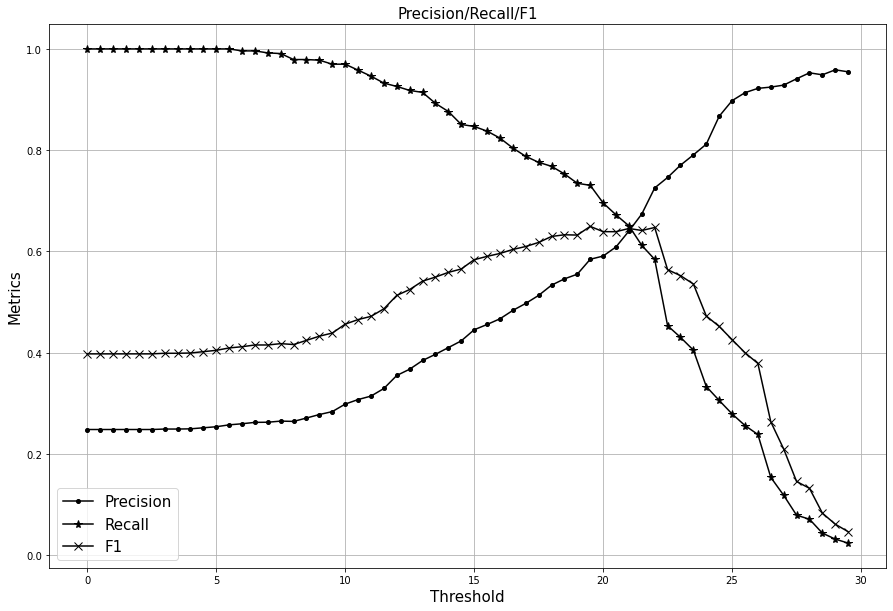

In [7]:
modelQA.rocplot(thre_start=0,thre_end=30,step=0.5,saveto="../results/rocQA.png")

In [4]:
modelQA.trec_eval(metrics=['map', 'ndcg_cut_1','ndcg_cut_3'])

{'map': 0.8082895888013999, 'ndcg_cut_1': 0.6889763779527559, 'ndcg_cut_3': 0.8309625866068141}


In [306]:
modelQQ=Model('../model/covid8','../ROCdata/testQQ.tsv')
modelQQ.run()

[ warning: overriding opt['model_file'] to ../model/covid8 (previously: model/poly2/covid8 )]
[ warning: overriding opt['single_turn'] to True (previously: None )]
[ warning: overriding opt['inference'] to topp (previously: max )]
[ warning: overriding opt['topp'] to 10.0 (previously: None )]
[ warning: overriding opt['ground_truth_path'] to ../ROCdata/testQQ.tsv (previously: None )]
Dictionary: loading dictionary from ../model/covid8.dict
[ num words =  54944 ]
[Polyencoder: full interactive mode on.]
[setting fixed_candidates path to: ../model/covid8.cands-convai2.cands ]
Total parameters: 256131072
Trainable parameters:  256131072
Loading existing model parameters from ../model/covid8
[ Loading fixed candidate set from ../model/covid8.cands-convai2.cands ]
[ Loading fixed candidate set vectors from ../model/covid8.covid8.cands-convai2.vecs ]
[ Loading fixed candidate set encodings from ../model/covid8.covid8.cands-convai2.encs ]
opening ground_truth_path
successfully opened ground_t

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.4172, 0.5185, 0.3000, 0.3422, 0.2702]])
original_scores: tensor([22.0097, 28.7988, 14.9185, 16.5924, 13.9354])
9
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: How long does the virus live on surfaces, like packages, plastic, etc? Should we be worried about that?
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.7173, 0.6073, 0.3001, 0.4441, 0.3712]])
original_scores: tensor([36.8696, 31.9926, 14.6506, 22.0246, 19.2405])
10
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: What is a coronavirus?
Enter Your

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.5739, 0.5022, 0.5187, 0.3335, 0.1919]])
original_scores: tensor([29.4162, 26.4654, 28.6340, 17.1925,  9.4620])
27
precision: 0.25
recall: 1.0
f1: 0.4
[Polyencoder]: What are the symptoms of COVID-19?
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.3990, 0.4800, 0.3992, 0.2607, 0.3028]])
original_scores: tensor([18.4841, 22.9300, 20.9143, 11.9125, 14.4863])
28
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: How many Covid19 cases have been reported in my country?
Enter Your Message: Starting eval
[ Vectorizing fixed candi

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.7028, 0.4295, 0.6382, 0.5661, 0.5470]])
original_scores: tensor([34.4319, 20.4593, 32.2436, 27.9901, 27.4424])
46
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: What are the symptoms of COVID-19?
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.5739, 0.5022, 0.5187, 0.3335, 0.1919]])
original_scores: tensor([29.4162, 26.4654, 28.6340, 17.1925,  9.4620])
47
precision: 0.25
recall: 1.0
f1: 0.4
[Polyencoder]: What are the symptoms of COVID-19?
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) 

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.5856, 0.5283, 0.3250, 0.3565, 0.6131]])
original_scores: tensor([31.3551, 25.7042, 15.7344, 17.8529, 32.8203])
65
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: What is a coronavirus?
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.5739, 0.5022, 0.5187, 0.3335, 0.1919]])
original_scores: tensor([29.4162, 26.4654, 28.6340, 17.1925,  9.4620])
66
precision: 0.25
recall: 1.0
f1: 0.4
[Polyencoder]: What are the symptoms of COVID-19?
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.6561, 0.4996, 0.1870, 0.3373, 0.3527]])
original_scores: tensor([31.0492, 25.5584,  9.7110, 16.9578, 17.8165])
83
precision: 0.25
recall: 1.0
f1: 0.4
[Polyencoder]: How does COVID-19 spread?
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.6046, 0.4310, 0.3228, 0.2765, 0.5065]])
original_scores: tensor([28.6161, 21.9685, 16.2079, 14.3049, 23.5888])
84
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: How does COVID-19 spread?
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ 

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.6702, 0.4519, 0.6011, 0.5343, 0.5324]])
original_scores: tensor([33.4609, 21.6074, 30.9863, 26.4792, 27.0592])
101
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: What are the symptoms of COVID-19?
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.5739, 0.5022, 0.5187, 0.3335, 0.1919]])
original_scores: tensor([29.4162, 26.4654, 28.6340, 17.1925,  9.4620])
102
precision: 0.25
recall: 1.0
f1: 0.4
[Polyencoder]: What are the symptoms of COVID-19?
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.5739, 0.5022, 0.5187, 0.3335, 0.1919]])
original_scores: tensor([29.4162, 26.4654, 28.6340, 17.1925,  9.4620])
118
precision: 0.25
recall: 1.0
f1: 0.4
[Polyencoder]: What are the symptoms of COVID-19?
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.6599, 0.3045, 0.1443, 0.2454, 0.3962]])
original_scores: tensor([32.5917, 14.3094,  6.9829, 11.2827, 17.1229])
119
precision: 0.25
recall: 1.0
f1: 0.4
[Polyencoder]: Should I wear a face mask?
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vec

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.5222, 0.2323, 0.3242, 0.4812, 0.3744]])
original_scores: tensor([28.2962, 10.5110, 15.7718, 26.6039, 17.0364])
137
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: I have read that CV is able to be contracted through the air, how far can it go in the air?
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.3305, 0.2925, 0.2558, 0.5586, 0.3824]])
original_scores: tensor([16.1506, 14.4651, 12.1946, 27.8534, 20.9798])
138
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: Has anyone gotten infected in the United S

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.3325, 0.3537, 0.3418, 0.2140, 0.3345]])
original_scores: tensor([16.1145, 18.7225, 17.4407, 10.0249, 15.8965])
155
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: How long does the virus live on surfaces, like packages, plastic, etc? Should we be worried about that?
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.2876, 0.3760, 0.4341, 0.3195, 0.2923]])
original_scores: tensor([13.5150, 18.2049, 22.4574, 16.8569, 13.7808])
156
precision: 0.4
recall: 1.0
f1: 0.5714285714285715
[Polyencoder]: There have been a lot of mixed 

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.5739, 0.5022, 0.5187, 0.3335, 0.1919]])
original_scores: tensor([29.4162, 26.4654, 28.6340, 17.1925,  9.4620])
173
precision: 0.25
recall: 1.0
f1: 0.4
[Polyencoder]: What are the symptoms of COVID-19?
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.7183, 0.4290, 0.6555, 0.5744, 0.5631]])
original_scores: tensor([35.7201, 20.7469, 33.6337, 28.8450, 28.7066])
174
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: What are the symptoms of COVID-19?
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.5839, 0.5106, 0.5014, 0.6027, 0.3682]])
original_scores: tensor([28.9655, 26.4196, 25.6862, 32.0482, 19.6746])
191
precision: 0.6
recall: 1.0
f1: 0.7499999999999999
[Polyencoder]: Should the general population wear masks to protect themselves from COVID-19?
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.4846, 0.4785, 0.5844, 0.4083, 0.2312]])
original_scores: tensor([25.0850, 26.0933, 30.7667, 22.5709, 11.9912])
192
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: Are symptoms of COVID-19 different in children?
Enter You

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.5998, 0.5579, 0.4946, 0.3953, 0.3477]])
original_scores: tensor([28.7117, 27.7378, 25.4659, 18.3454, 16.4399])
209
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: What are the symptoms of COVID-19?
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.3428, 0.2011, 0.3490, 0.3698, 0.2834]])
original_scores: tensor([15.7372,  9.5581, 15.7132, 18.4437, 14.1498])
210
precision: 0.25
recall: 1.0
f1: 0.4
[Polyencoder]: Can COVID-19 be spread through food (including refrigerated or frozen food)?
Enter Your Message: Starting eval
[ V

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.6443, 0.6338, 0.3643, 0.3204, 0.5103]])
original_scores: tensor([34.6791, 32.7448, 18.0335, 15.7861, 25.7756])
227
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: What is social distancing and how does it help to minimize COVID-19?
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.6889, 0.4238, 0.6305, 0.5628, 0.5396]])
original_scores: tensor([33.9402, 20.4056, 32.0542, 28.1350, 27.3132])
228
precision: 0.2
recall: 1.0
f1: 0.33333333333333337
[Polyencoder]: What are the symptoms of COVID-19?
Enter Your Message: Starting e

Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.4230, 0.2812, 0.3907, 0.3177, 0.3933]])
original_scores: tensor([22.1329, 15.2536, 20.8035, 15.5546, 19.5556])
245
precision: 0.4
recall: 1.0
f1: 0.5714285714285715
[Polyencoder]: Can COVID-19 be spread through food (including refrigerated or frozen food)?
Enter Your Message: Starting eval
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Vectorizing fixed candidate set (1 batch(es) of up to 512) ]
[ Encoding fixed candidates set from (1 batch(es) of up to 256) ]
cosine_scores: tensor([[0.5343, 0.4508, 0.4792, 0.4140, 0.1814]])
original_scores: tensor([27.2100, 23.7472, 26.1879, 21.5346,  8.9791])
246
precision: 0.25
recall: 1.0
f1: 0.4
[Polyencoder]: What are the symptoms of COVID-19?
Enter Your Message: Starting eval
[ Ve

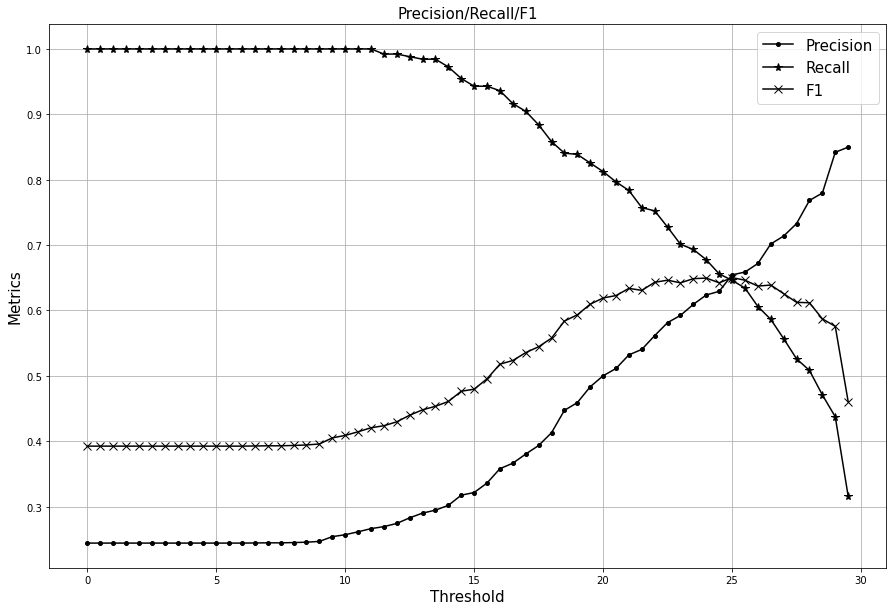

In [307]:
modelQQ.rocplot(thre_start=0,thre_end=30,step=0.5,saveto="../results/rocQQ.png")

In [308]:
modelQQ.trec_eval(metrics=['map', 'ndcg_cut_1','ndcg_cut_3'])

{'map': 0.8414041994750656, 'ndcg_cut_1': 0.7755905511811023, 'ndcg_cut_3': 0.8446761621504885}


In [ ]:
max(model.ps),max(modelQQ.ps)

In [298]:
modelQQ.ps

[0.2440944881889764,
 0.2440944881889764,
 0.2440944881889764,
 0.2440944881889764,
 0.2440944881889764,
 0.2440944881889764,
 0.2440944881889764,
 0.2440944881889764,
 0.2440944881889764,
 0.2440944881889764,
 0.2440944881889764,
 0.2440944881889764,
 0.2440944881889764,
 0.24429133858267718,
 0.24448818897637797,
 0.24448818897637797,
 0.24488188976377956,
 0.2454724409448819,
 0.24665354330708664,
 0.25393700787401574,
 0.25688976377952755,
 0.26135170603674546,
 0.26620734908136484,
 0.2692913385826772,
 0.27414698162729656,
 0.282742782152231,
 0.28996062992125987,
 0.294488188976378,
 0.3018372703412074,
 0.3173884514435696,
 0.32145669291338586,
 0.3359580052493439,
 0.3579396325459317,
 0.3662729658792651,
 0.38031496062992126,
 0.3933727034120735,
 0.4129265091863517,
 0.44717847769028873,
 0.45892388451443566,
 0.4832020997375328,
 0.5000000000000001,
 0.5111548556430446,
 0.532020997375328,
 0.5403543307086615,
 0.5614829396325459,
 0.5813648293963255,
 0.5923884514435696,
 

(0.5, 1.0, 0.6666666666666666)